In [24]:
from scipy.stats import norm, t
import scipy
import numpy as np
import pandas as pd

from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns


def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, sigma, r, N):
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
  u = np.exp(sigma * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)
    
  C = np.empty(n_nodes(N), dtype=float)
            
  for i in np.arange(N, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      index = node_index(j, i)
      C[index] = max(0, (S - X) * is_call)
      if i < N:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
        C[index] = max(C[index], val)
                
  return C[0]



def binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N):
  if div_date is None or div is None:
    return binomial_tree_no_div(option_type, S0, X, T, sigma, r, N)
  
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
    
  #calculate u, d, and p
  u = np.exp(sigma * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)

  new_T = T - div_time * dt
  new_N = N - div_time

  C = np.empty(n_nodes(div_time), dtype=float)
  for i in range(div_time, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      val_exe = max(0, (S - X) * is_call)
      if i < div_time:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
      else:
        val = binomial_tree(option_type, S - div, X, new_T, None, None, sigma, r, new_N)
      C[node_index(j, i)] = max(val_exe, val)
    
  return C[0]

def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
  def equation(sigma):
    return binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N) - market_price
  # Back solve the binomial tree valuation to get the implied volatility
  return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      # For stock, the single value is its price
      single_values = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      sigma = portfolios["ImpliedVol"][i]
      div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
      div = 1
      option_values = []
      for S in sim_prices:
        option_values.append(binomial_tree(option_type, S, X, T, div_time, div, sigma, r, N))
      single_values = np.array(option_values)
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()

In [25]:
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    implied_vols.append(None)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = (portfolios["ExpirationDate"][i] - current_date).days / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    market_price = portfolios["CurrentPrice"][i]
    sigma = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
    implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

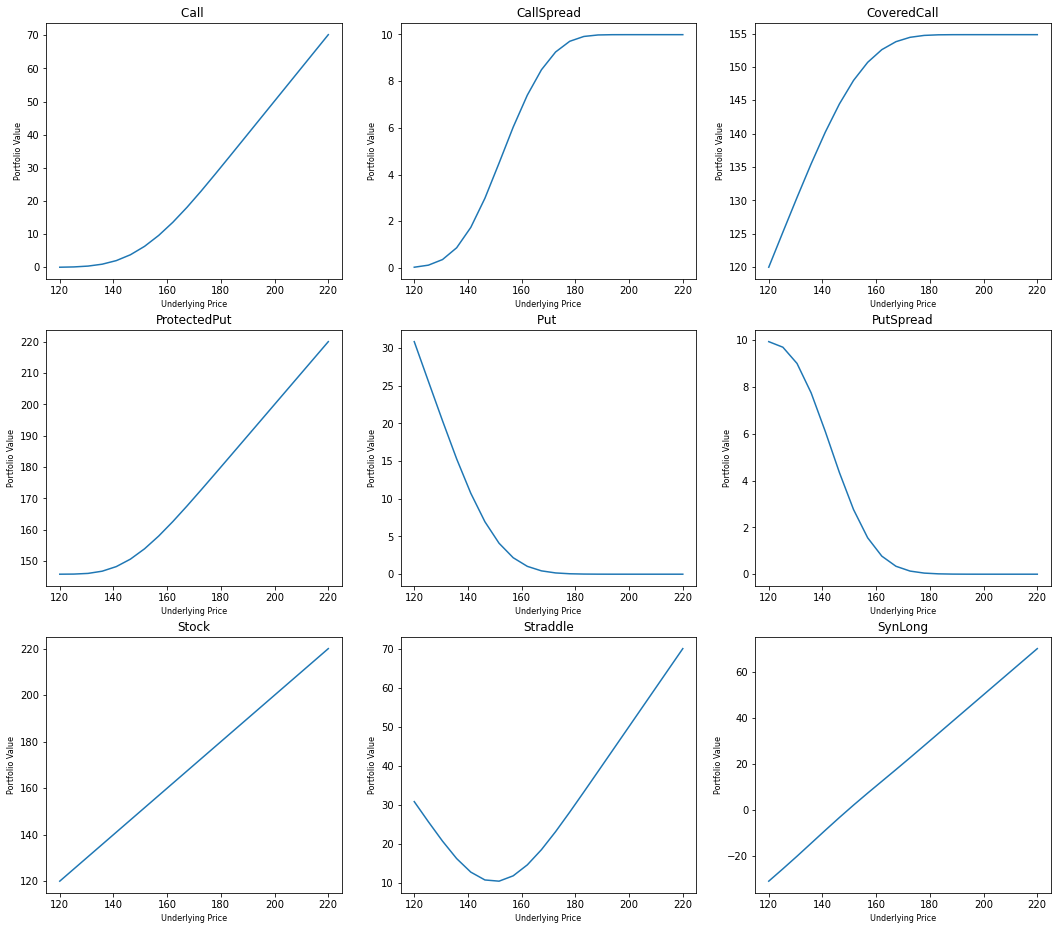

In [26]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
  i, j = idx // 3, idx % 3
  ax = axes[i][j]
  ax.plot(sim_prices, dataframe.iloc[0, :].values)
  ax.set_title(portfolio)
  ax.set_xlabel('Underlying Price', fontsize=8)
  ax.set_ylabel('Portfolio Value', fontsize=8)
  idx += 1

In [33]:
import pandas as pd


df = pd.read_csv('DailyPrices.csv')

# Calculate daily return
df['AAPL Daily Return'] = (df['AAPL'] / df['AAPL'].shift(1)) - 1

# Print the daily return column
print(df['AAPL Daily Return'])

0           NaN
1      0.023152
2     -0.001389
3     -0.021269
4     -0.009356
         ...   
244    0.024400
245   -0.017929
246    0.019245
247   -0.017653
248   -0.006912
Name: AAPL Daily Return, Length: 249, dtype: float64


In [34]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

def calculate_var(data, mean=0, alpha=0.05):
  return mean - np.quantile(data, alpha)

def calculate_es(data, mean=0, alpha=0.05):
  var = calculate_var(data, mean, alpha)
  return -np.mean(data[data <= -var])


# Simulate the prices based on returns with normal distribution
std = df['AAPL Daily Return'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = S * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:calculate_es(x), axis=1)
result

,Mean,VaR,ES
Portfolio,,,
Call,-0.126615,6.201060,6.562662
CallSpread,-0.525887,4.030262,4.362484
CoveredCall,-1.733921,13.923459,18.803451
ProtectedPut,0.043535,7.651911,8.041389
Put,1.954384,4.356013,4.649988
PutSpread,0.818833,2.628327,2.854175
Stock,-1.510773,17.813569,22.800091
Straddle,1.827769,1.347783,1.385781
SynLong,-2.080999,19.084993,24.336698


In [37]:
import inspect

# calculate first order derivative
def first_order_der(func, x, delta):
  return (func(x + delta) - func(x - delta)) / (2 * delta)

# calculate second order derivative
def second_order_der(func, x, delta):
  return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
  # initialize for argument names and order
  arg_names = list(inspect.signature(func).parameters.keys())
  derivative_fs = {1: first_order_der, 2: second_order_der}

  def partial_derivative(*args, **kwargs):
    # parse argument names and order
    args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
    arg_val = args_dict.pop(arg_name)

    def partial_f(x):
      p_kwargs = {arg_name:x, **args_dict}
      return func(**p_kwargs)
    return derivative_fs[order](partial_f, arg_val, delta)
  return partial_derivative
     

In [38]:
cal_amr_delta_num =  cal_partial_derivative(binomial_tree, 1, 'S0')

# Calculate the implied volatility for all portfolios
deltas = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    deltas.append(1)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, sigma, r, N)
    deltas.append(delta)

# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
  gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
  pfl_10d_std = abs(gradient) * std * np.sqrt(t)
  N = scipy.stats.norm(0, 1)
  present_value = df['CurrentValue'].sum() 
  result_dn.loc[pfl]['Mean'] = 0
  result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
  result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn

,Mean,VaR,ES
Portfolio,,,
Call,0,9.51986,11.938288
CallSpread,0,5.26384,6.601068
CoveredCall,0,10.901461,13.670872
ProtectedPut,0,12.141348,15.225741
Put,0,8.187534,10.267498
PutSpread,0,4.91698,6.166092
Stock,0,17.627131,22.105134
Straddle,0,1.332326,1.67079
SynLong,0,17.707393,22.205786
